In this notebook we look at the distribution of interest for each country over an large number of pages.

In theory, over a *large enough* sample, the observed distribution of interests should match the expected distribution of interests.

We want to verify that this is actually the case, and whether this is the case or not for pages in particular categories.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import btb.utils.tools as btbtools
import btb.utils.wikiquery as wq

import mwclient
import pickle
from collections import defaultdict
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
from IPython.display import Image

from glob import glob

In [3]:
wikiEN = mwclient.Site('en.wikipedia.org')
bots = wq.getAllBots(wikiEN)
expEdPct = wq.getTotalContributions() # Expected percentage of edits per country

In [4]:
def randomTitles(wikiEN, nTitles):
    '''
    Generator of random Wikipedia pages.
    '''
    for i in range(int(nTitles/10)):
        randPages = wikiEN.random(namespace=0, limit=10)
        for page in randPages:
            yield page['title']

In [5]:
def categoryTitles(wikiEN, catName, nTitles):
    '''
    Generator of random Wikipedia pages in a category.
    
    NOTE: ordering of items in the category is always the same.
    
    eg: categoryTitles(wikiEN, 'Cities in the Netherlands', 20)
    '''
    wikiCat = wikiEN.categories[catName]
    for i in range(nTitles):
        catPage = wikiCat.next()
        yield catPage.name

In [6]:
def unpackContributions(cmpEdits):
    ''' previously dict comprehension: 
    { ctry: ac for ctry,(ex,ac,cm) in cmpEdits.iteritems() } 
    
    except added an if  to avoid empty keys which cause problems 
    when pickling '''
    edits = {}
    for ctry,(ex,ac,cm) in cmpEdits.iteritems():
        if ctry=='':
            ctry = '_'
        edits[ctry] = ac
    return edits

def fetchContributions(titles):
    '''
    Parameters:
        titles    Generator of titles to be fetched
    Return:
        dictionary of title: contribution percentages
    '''
    cumEdCount = []
    for pageTitle in titles:
        ips, usrs, nrevs = wq.getContributionsForPage(wikiEN, pageTitle)
        revCount, conf, nIP, nUsr, nBot, nUnkn = btbtools.prepareData(ips, usrs, bots)

        # Blank keys cause pickling problems
        if '' in revCount.keys():
            del revCount['']
        
        cumEdCount.append((pageTitle, revCount))
    return cumEdCount

In [7]:
def getContributionSummary(pageContribs):
    '''
    Summarize a list of page contributions to a single distribution of contributions.
    
    Parameters:
    pageContribs  a list of tuples containing title,contribution_percentage
    
    Returns:
    A dictionary of contributions where the key is the name of the country, and 
    the value is the percentage of contributions from that country.
    '''
    # Normalization factor:
    # Weight each contribution by a normalization factor dependent on the 
    # total weight of all contributions -- this makes returned map add up to 1.
    normFactor = sum( sum(contribs.values()) for _,contribs in pageContribs )
    
    edPct = defaultdict(float)
    for title,pageEdPct in pageContribs:
        for ctry,pct in pageEdPct.iteritems():
            edPct[ctry] += pct / normFactor
    return edPct

In [8]:
def getEditError(globalContribsPct):
    '''
    Calculate the error present in the given list of global contributions. Error 
    is calculated as the squared difference between the observed contributions 
    and the expected contributions (known from wikistats).
    
    Parameters:
    globalContribsPct   Dictionary containing percentage of contributions by country.
                        (should add up to 1).
    
    Returns
    The sum squared difference between observed and expected.
    '''
    assert sum(globalContribsPct.values())<1.1, 'Global contributions should add up to 1' # Plus 10% margin
    editDiff = []
    for e in expEdPct:
        ex = expEdPct[e]
        ac = globalContribsPct[e] if e in globalContribsPct else 0
        editDiff.append(ac-ex)
    editDiff = np.array(editDiff)
    return (editDiff**2).sum()

In [9]:
def plotContribError(pageContribs):
    '''
    Plot the cumulative editError of a list of contributions.
    
    Parameters:
    pageContribs  a list of tuples containing title,contribution_percentage 
    '''
    err = []
    cumContribsCount = defaultdict(float)
    
    for pageTitle, pageContribCount in pageContribs:
        for ctry,edCount in pageContribCount.iteritems():
            cumContribsCount[ctry] += edCount
        cmpEdits = btbtools.compareEdits(expEdPct, cumContribsCount)
        cumContribsPct = unpackContributions(cmpEdits)
        err.append(getEditError(cumContribsPct))

    semilogy(err)
    axis([ 0, len(pageContribs), 0, 1])
    xlabel('# sampled pages')
    ylabel('Error')


In [10]:
def plotHistogramContributions(pageContribs, fig=None):
    '''
    Draw cumulative histogram on a list of contributions
    
    Parameters:
    pageContribs  a list of tuples containing title,contribution_percentage 
    '''
    if fig==None:
        figure(figsize=(12,4))

    actEdPct = getContributionSummary(pageContribs)

    tags   = np.array(expEdPct.keys())
    cmpVals = np.array(expEdPct.values())

    # Sort descending by expected value
    sortIdx = cmpVals.argsort()
    sortIdx = sortIdx[::-1]
    tags   = tags[sortIdx]

    expVal = [ expEdPct[ctry] for ctry in tags ]
    actVal = [ actEdPct[ctry] for ctry in tags ]

    # Format bar charts
    width = 0.35
    N = len(tags)
    ind = np.arange(N)

    bar(ind           , expVal, width=width, color='y', label='Expectation')
    bar(ind + width   , actVal, width=width, color='r', label='Contribution')
    xticks(ind + width, tags  , rotation=90)

# Fetch data from Wikipedia
Fetch data from different samples of random pages and categories

In [81]:
import datetime
def printTimestampMessage(msg=''):
    currTime = datetime.datetime.now()
    print currTime.strftime('[%H:%M:%S]'),msg

In [71]:
titles = randomTitles(wikiEN, 500)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribsRandom.pkl', 'w'))

In [ ]:
printTimestampMessage('Start')
titles = categoryTitles(wikiEN, 'Cities in the Netherlands', 500)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribs_citiesNL.pkl', 'w'))
printTimestampMessage('Finish')

In [ ]:
titles = randomTitles(wikiEN, 1000)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribsRandom1000A.pkl', 'w'))

# Plot data
Let's have a look at some of the collected results.

In [11]:
def makeFrame(i, pageContribs):
    '''
    Generate the i-th frame for an animation. Frame contains the cumulative histrogram
    at step i of the list.
    
    Parameters:
    i             Number of frame to be created
    pageContribs  a list of tuples containing title,contribution_percentage 
    
    Returns:
    An image of the cumulative histogram.
    '''
    gcf().clear()
    plotHistogramContributions(pageContribs[:i], gcf())
    title('Title %d'%i)
    img = mplfig_to_npimage(gcf())
    return img

def wrapMakeFrame(f, pageContribs, fps):
    '''
    Wrapper for makeFrame function
    '''
    i = int(f * fps)+1
    return makeFrame(i, pageContribs)

def buildAnimation(pageContribs, aniFile, duration):
    '''
    Create an animation from the given list of page contributions.
    
    Parameters:
    pageContribs  a list of tuples containing title,contribution_percentage 
    aniFile       Filename of the animation to be created
    duration      Desired duration of the animation (in seconds).
    '''
    fps = len(pageContribs) / duration
    trueFps = fps if fps<24 else 24
    
    fig = figure(figsize=(12,4))
    lambdaMakeFrame = lambda f: wrapMakeFrame(f, pageContribs, fps)

    animation =mpy.VideoClip(lambdaMakeFrame, duration=duration)
    animation.write_gif(aniFile, fps=trueFps)
    close()

## 500 random Wikipedia pages
Results from 500 random wikipedia pages

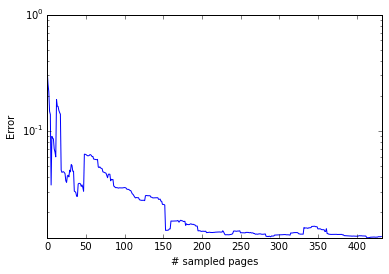

In [24]:
pageContribs = pickle.load(open('PageContribsRandom.pkl', 'r'))
plotContribError(pageContribs)

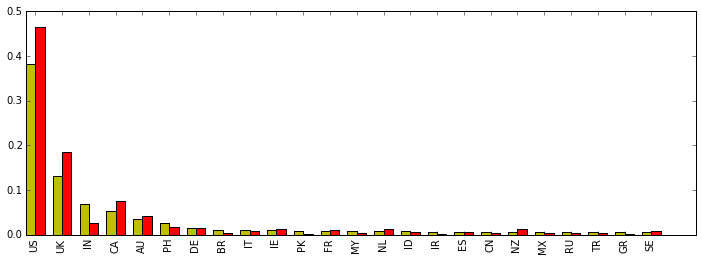

In [113]:
plotHistogramContributions(pageContribs)

In [116]:
buildAnimation(pageContribs, 'random.gif', duration=20)
Image(url='random.gif')

## Category: cities in the netherlands
Results from Category: cities in the netherlands

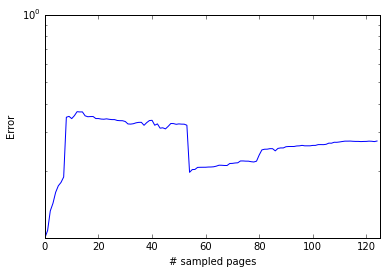

In [15]:
pageContribs = pickle.load(open('PageContribs_citiesNL.pkl', 'r'))
plotContribError(pageContribs)

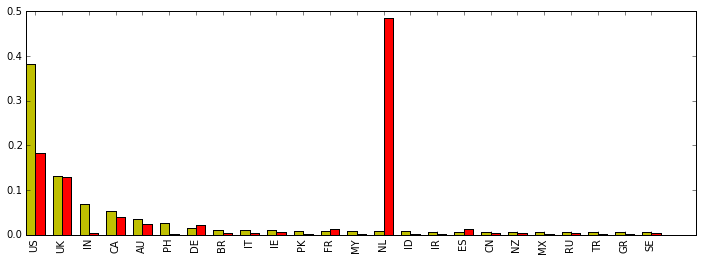

In [122]:
plotHistogramContributions(pageContribs)

In [121]:
buildAnimation(pageContribs, 'cities_nl.gif', duration=20)

Image(url='cities_nl.gif')

## Category: Tram transport in Germany
Results from Category: Tram transport in Germany

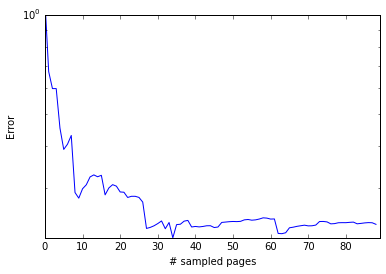

In [16]:
pageContribs = pickle.load(open('PageContribs_Tram_transport_in_Germany.pkl', 'r'))
plotContribError(pageContribs)

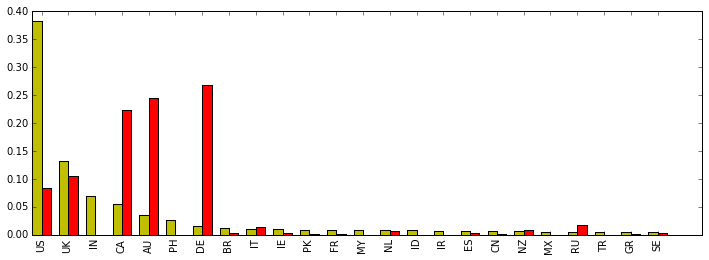

In [180]:
plotHistogramContributions(pageContribs)

In [181]:
buildAnimation(pageContribs, 'PageContribs_Tram_transport_in_Germany.gif', duration=20)
Image(url='PageContribs_Tram_transport_in_Germany.gif')


[MoviePy] Building file PageContribs_Tram_transport_in_Germany.gif with imageio


## Category: Crops originating from the Americas
Results from Category: Crops originating from the Americas

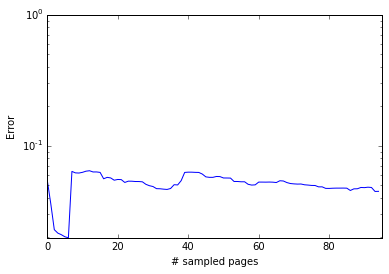

In [17]:
pageContribs = pickle.load(open('PageContribs_Crops originating from the Americas.pkl', 'r'))
plotContribError(pageContribs)

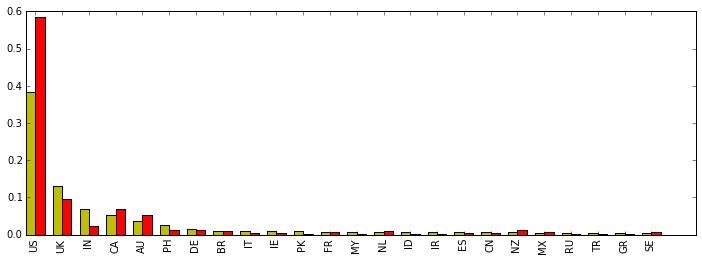

In [183]:
plotHistogramContributions(pageContribs)

In [184]:
buildAnimation(pageContribs, 'PageContribs_Crops originating from the Americas.gif', duration=20)
Image(url='PageContribs_Crops originating from the Americas.gif')


[MoviePy] Building file PageContribs_Crops originating from the Americas.gif with imageio


## Category: German heavy metal musical groups
Results from Category: German heavy metal musical groups

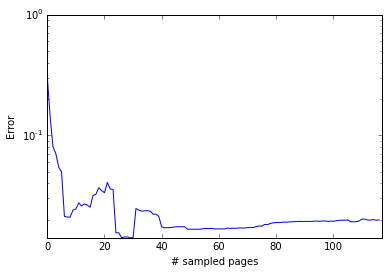

In [18]:
pageContribs = pickle.load(open('PageContribs_German heavy metal musical groups.pkl', 'r'))
plotContribError(pageContribs)

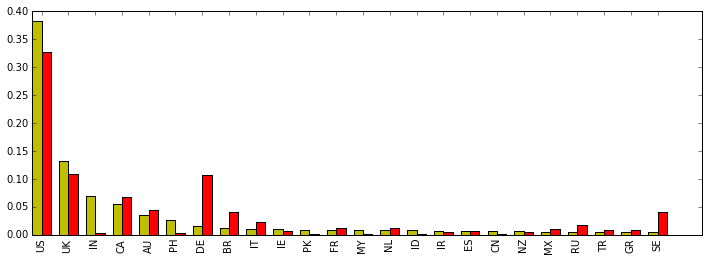

In [186]:
plotHistogramContributions(pageContribs)

In [187]:
buildAnimation(pageContribs, 'PageContribs_German heavy metal musical groups.gif', duration=20)
Image(url='PageContribs_German heavy metal musical groups.gif')


[MoviePy] Building file PageContribs_German heavy metal musical groups.gif with imageio


## Random 1000
Results 1000 random wikipedia pages

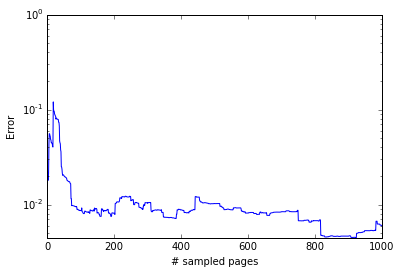

In [20]:
pageContribs = pickle.load(open('PageContribsRandom1000A.pkl', 'r'))
plotContribError(pageContribs)

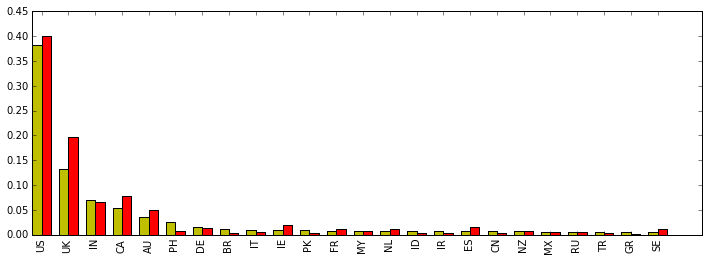

In [126]:
plotHistogramContributions(pageContribs)

In [127]:
buildAnimation(pageContribs, 'PageContribsRandom1000A.gif', duration=20)
Image(url='PageContribsRandom1000A.gif')


[MoviePy] Building file PageContribsRandom1000A.gif with imageio


## Random 9000
Results 9000 random wikipedia pages

In [22]:
pageContribs = []
allTitles = set()

for filename in glob('PageContribsRandom1000*.pkl'):
    pklData = pickle.load(open(filename, 'r'))
    for pageTitle,dist in pklData:
        if pageTitle in allTitles:
            print 'Repeated: ',pageTitle
        else:
            allTitles.add(pageTitle)
            pageContribs.append((pageTitle,dist))
    

Repeated:  Kallam Anji Reddy
Repeated:  Sagentia
Repeated:  Penzing, Bavaria
Repeated:  R. C. Robertson-Glasgow
Repeated:  AN/SPS-43
Repeated:  Karakobis
Repeated:  Ghost Stories Tour
Repeated:  Jack Cattell
Repeated:  St Michaels & Wicksteed (Kettering BC Ward)
Repeated:  Bridgend Designer Outlet


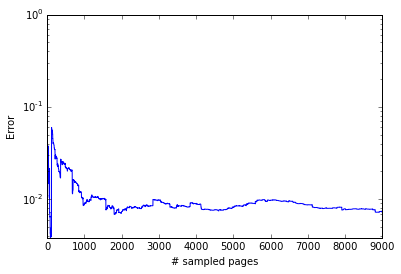

In [23]:
plotContribError(pageContribs)

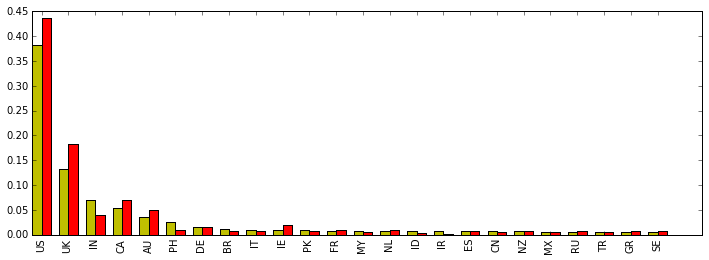

In [172]:
plotHistogramContributions(pageContribs)

In [173]:
buildAnimation(pageContribs, 'PageContribsRandom-all.gif', duration=20)
Image(url='PageContribsRandom-all.gif')


[MoviePy] Building file PageContribsRandom-all.gif with imageio


# A closer look
It seems like UK and US have 'higher than expected' percentages of contributuions. Lets have a closer look at the pages which have a higher than usual number of edits from the UK.

0.377975528365
14.31783402


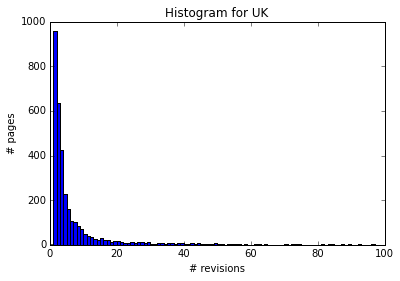

In [209]:
allBritish = []
n = 0
britishRevs = []
for pageTitle, contribs in pageContribs:
    cmpEdits = btbtools.compareEdits(expEdPct, contribs)
    contribsPct = unpackContributions(cmpEdits)
    if 'UK' in contribsPct and contribsPct['UK']>0.15:
        n += 1
        allBritish.append(pageTitle)
        britishRevs.append(contribs['UK'])
print n/len(pageContribs)
print np.mean(britishRevs)

hist(britishRevs, bins=arange(0,100,1))
xlabel('# revisions')
ylabel('# pages')
title('Histogram for UK')

0.353281423804
40.0324307305


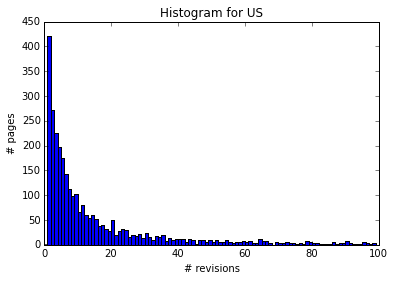

In [210]:
allBritish = []
n = 0
britishRevs = []
for pageTitle, contribs in pageContribs:
    cmpEdits = btbtools.compareEdits(expEdPct, contribs)
    contribsPct = unpackContributions(cmpEdits)
    if 'US' in contribsPct and contribsPct['US']>0.40:
        n += 1
        allBritish.append(pageTitle)
        britishRevs.append(contribs['US'])
print n/len(pageContribs)
print np.mean(britishRevs)

hist(britishRevs, bins=arange(0,100,1))
xlabel('# revisions')
ylabel('# pages')
title('Histogram for US')

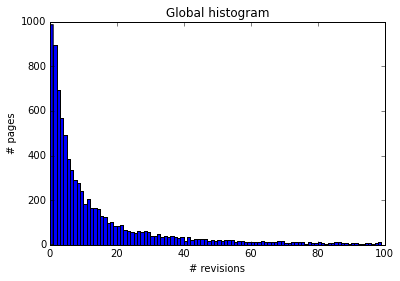

In [211]:
totalRevs = []
for pageTitle, contribs in pageContribs:
    totalRevs.append(sum(contribs.values()))
hist(totalRevs, bins=arange(0,100,1));
np.mean(totalRevs)

xlabel('# revisions')
ylabel('# pages')
title('Global histogram')

These histograms show the number of contributions per page. It appears to be that pages which have a higher than usual contributions from the UK and US, tend to have a lower number of contributions than the global number of contributions.

This implies that there are a number of small pages mostly edited by UK users. Another possibility is that UK users have a different behaviour to other wikipedians. However either theory would need to be verified.